In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

In [2]:
df = pd.read_csv("generated_molecules.csv")
df.head()

,Molecule
0,CCCCC(=O)NC[C@@H](CCCC)NC(=O)CCNC(N)=O
1,C[C@H](NC1CC1)C(=O)N[C@@H](CO)c1cccc(F)c1
2,C=CCCN1C[C@@H](C)[C@H](CCNC(=O)COc2ccco2)C1
3,CCc1sc(C(=O)N[C@H]2CCCNC2=O)c2ccccc2c1CCC2
4,CC[C@H](F)C(=O)NCCNCC(=O)N1CCC[C@@H](C(N)=O)C1


In [3]:
import torch
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [4]:
from rdkit import Chem
from rdkit import RDLogger


# Function to check if a molecule is valid
def is_valid_molecule(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        return 1 if mol else 0
    except:
        return 0
# Disable RDKit warnings
# RDLogger.DisableLog('rdApp.*')

# Apply the function to each row in the 'Molecule' column
df['is_valid'] = df['Molecule'].apply(is_valid_molecule)

df.describe()

[16:16:23] SMILES Parse Error: unclosed ring for input: 'CCc1sc(C(=O)N[C@H]2CCCNC2=O)c2ccccc2c1CCC2'
[16:16:23] non-ring atom 10 marked aromatic
[16:16:23] SMILES Parse Error: syntax error while parsing: CONC(=O)CCCc1ccc(
[16:16:23] SMILES Parse Error: Failed parsing SMILES 'CONC(=O)CCCc1ccc(' for input: 'CONC(=O)CCCc1ccc('
[16:16:23] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[16:16:23] SMILES Parse Error: unclosed ring for input: 'COc1cc(/C=C/C(=O)NCCC(C)(C)C(=O)O)'
[16:16:23] SMILES Parse Error: syntax error while parsing: CC(=O)C(=O)N1C[C@@H]2CC(=O)N()[C@@H]2C1
[16:16:23] SMILES Parse Error: Failed parsing SMILES 'CC(=O)C(=O)N1C[C@@H]2CC(=O)N()[C@@H]2C1' for input: 'CC(=O)C(=O)N1C[C@@H]2CC(=O)N()[C@@H]2C1'
[16:16:23] SMILES Parse Error: extra close parentheses while parsing: Cc1nnc2)c(-c3cnc(N)nc3)ccnn12
[16:16:23] SMILES Parse Error: Failed parsing SMILES 'Cc1nnc2)c(-c3cnc(N)nc3)ccnn12' for input: 'Cc1nnc2)c(-c3cnc(N)nc3)ccnn12'
[16:16:23] Explicit valence for atom # 3 C, 5

,is_valid
count,10030.000000
mean,0.934995
std,0.246547
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


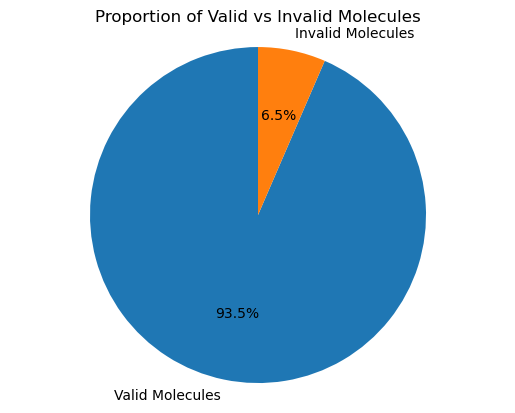

In [5]:
# Count the number of valid and invalid molecules
valid_count = df['is_valid'].sum()
invalid_count = len(df) - valid_count

# Data for plotting
labels = ['Valid Molecules', 'Invalid Molecules']
sizes = [valid_count, invalid_count]

# Plot
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title("Proportion of Valid vs Invalid Molecules")
plt.show()

In [6]:
# Clone the dataframe to create a new one with only valid molecules
valid_df = df[df['is_valid'] == 1].copy()
valid_df.head()

,Molecule,is_valid
0,CCCCC(=O)NC[C@@H](CCCC)NC(=O)CCNC(N)=O,1
1,C[C@H](NC1CC1)C(=O)N[C@@H](CO)c1cccc(F)c1,1
2,C=CCCN1C[C@@H](C)[C@H](CCNC(=O)COc2ccco2)C1,1
4,CC[C@H](F)C(=O)NCCNCC(=O)N1CCC[C@@H](C(N)=O)C1,1
5,CC(C)=C[C@@H]1[C@H](C(=O)N2CC[C@H](C(N)=O)C2)C...,1


In [7]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
import torch
from torch_geometric.data import Data
from tqdm import tqdm

def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)  # Add hydrogens
    AllChem.EmbedMolecule(mol, AllChem.ETKDG())  # Generate 3D coordinates

    # Node features
    node_feats = []
    for atom in mol.GetAtoms():
        atom_type = atom.GetAtomicNum()  # Atomic number as atom type
        charge = atom.GetFormalCharge()  # Formal charge
        hybridization = atom.GetHybridization()  # Hybridization
        valence = atom.GetTotalValence()  # Total valence
        degree = atom.GetDegree()  # Degree
        num_hydrogens = atom.GetTotalNumHs(includeNeighbors=True)  # Number of hydrogens
        chirality = atom.GetChiralTag()  # Chirality
        atomic_mass = atom.GetMass()  # Atomic mass
        aromatic = int(atom.GetIsAromatic())  # Aromatic (0 or 1)
        in_ring = int(atom.IsInRing())  # In ring (0 or 1)

        node_feats.append([atom_type, charge, hybridization, valence, degree,
                           num_hydrogens, chirality, atomic_mass, aromatic, in_ring])

    node_feats = torch.tensor(node_feats, dtype=torch.float)

    # Edge features
    edge_indices = []
    edge_feats = []
    for bond in mol.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_indices.append((start, end))
        edge_indices.append((end, start))  # Undirected graph

        bond_type = bond.GetBondTypeAsDouble()
        aromatic = int(bond.GetIsAromatic())
        stereo = bond.GetStereo()
        is_conjugated = int(bond.GetIsConjugated())

        edge_feats.extend([[bond_type, aromatic,  stereo, is_conjugated]] * 2)

    edge_feats = torch.tensor(edge_feats, dtype=torch.float)
    edge_indices = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()

    graph = Data(x=node_feats.to(device), edge_index=edge_indices.to(device), edge_attr=edge_feats.to(device))
    return graph

graphs = [smiles_to_graph(smiles) for smiles in tqdm(valid_df['Molecule'], desc="Processing Molecules")]


Processing Molecules: 100%|██████████| 9378/9378 [24:42<00:00,  6.33it/s]


In [8]:
import pickle

# Save the list of graphs as a pickle file
with open('./datasets/generated_molecules_graphs.pkl', 'wb') as f:
    pickle.dump(graphs, f)

In [9]:
import torch
import torch.nn as nn
import torch_geometric.nn as geom_nn
from torch.nn import Linear
from torch_geometric.nn import GCNConv, global_mean_pool
import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import GINConv, global_add_pool

class GINNet(torch.nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(GINNet, self).__init__()
        x_num_features = 10
        e_num_features = 4
        dim = 256
        self.dim = dim

        # Define GINConv layers for node features
        x_nn1 = Sequential(Linear(x_num_features, dim), ReLU(), Linear(dim, dim))
        self.x_conv1 = GINConv(x_nn1)
        self.x_bn1 = torch.nn.BatchNorm1d(dim)
        self.dropout1 = nn.Dropout(dropout_rate)

        x_nn2 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.x_conv2 = GINConv(x_nn2)
        self.x_bn2 = torch.nn.BatchNorm1d(dim)
        self.dropout2 = nn.Dropout(dropout_rate)

        # Define layers for edge features
        self.e_linear = Sequential(Linear(e_num_features, 22),
                                   ReLU(),
                                   Linear(22, dim))  # Output dim should match node feature dim
        self.dropout_e = nn.Dropout(dropout_rate)

        # Define final linear layers (adjust the input size based on concatenated features)
        self.final_lin = Sequential(Linear(dim * 2, 512),  
                                    ReLU(),
                                    nn.Dropout(dropout_rate),
                                    Linear(512, 2))

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        # Apply GINConv layers, batch normalization, and dropout
        x = F.relu(self.x_conv1(x, edge_index))
        x = self.x_bn1(x)
        x = self.dropout1(x)
        x = F.relu(self.x_conv2(x, edge_index))
        x = self.x_bn2(x)
        x = self.dropout2(x)

        # Process edge features with dropout
        e = self.e_linear(edge_attr)
        e = self.dropout_e(e)

        # Aggregate edge features for each node
        row, col = edge_index
        aggregated_e = torch.zeros_like(x)
        aggregated_e = aggregated_e.index_add_(0, col, e)  # Aggregate to target nodes

        # Concatenate node features with aggregated edge features
        x = torch.cat([x, aggregated_e], dim=1)

        # Apply global pooling to concatenated features
        pooled = global_add_pool(x, batch)

        # Apply final linear layers
        out = self.final_lin(pooled)

        return out

model = GINNet(dropout_rate=0.35)  # Specify the dropout rate
model.load_state_dict(torch.load("./saved_models/gnn-ckpt.pth",map_location=device))
model = model.to(device)


In [10]:
from torch_geometric.loader import DataLoader


test_loader = DataLoader(graphs, batch_size=32, shuffle=False)

model.eval()  # Set the model to evaluation mode
predictions = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = model(data)
        probs = F.softmax(out, dim=1)[:, 1]  # Get probabilities of positive class
        predictions.extend(probs.cpu().numpy())

# Convert probabilities to binary predictions based on the threshold
threshold = 0.907889  # The best threshold
binary_predictions = [1 if p > threshold else 0 for p in predictions]




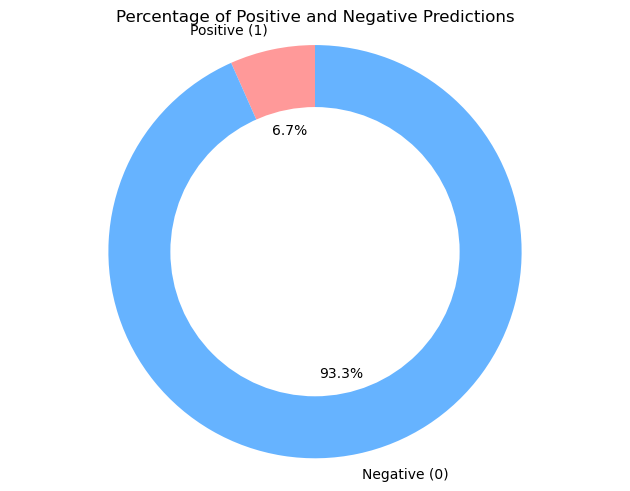

In [11]:
import matplotlib.pyplot as plt

# Assuming binary_predictions contains the predicted classes for each molecule
num_predictions = len(binary_predictions)
num_positives = sum(binary_predictions)
num_negatives = num_predictions - num_positives

# Calculating percentages
percentage_positives = (num_positives / num_predictions) * 100
percentage_negatives = (num_negatives / num_predictions) * 100

# Plotting
labels = ['Positive (1)', 'Negative (0)']
sizes = [percentage_positives, percentage_negatives]
colors = ['#ff9999','#66b3ff']
 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title('Percentage of Positive and Negative Predictions')
plt.show()



In [20]:
active_df = valid_df.copy()
active_df['is_active'] = binary_predictions
active_df.describe()

,is_valid,is_active
count,9378.0,9378.000000
mean,1.0,0.066539
std,0.0,0.249235
min,1.0,0.000000
25%,1.0,0.000000
50%,1.0,0.000000
75%,1.0,0.000000
max,1.0,1.000000


In [21]:
active_df['is_active'].sum()

624

In [22]:
active_only_df = active_df[active_df['is_active'] == 1].copy()
active_only_df

,Molecule,is_valid,is_active
2,C=CCCN1C[C@@H](C)[C@H](CCNC(=O)COc2ccco2)C1,1,1
9,CC1(C(=O)NC[C@@H](CO)NC(=O)C(C)(C)c2cnc[nH]2)C...,1,1
50,CC(=O)NCC(=O)NCc1cn(C2CN([C@@H](C)C(=O)N(C)C)C...,1,1
51,C=CCCCC(=O)N1CCn2c(nnc2C(=O)N2CC=CC2)C[C@@H]1C,1,1
52,CCn1ncc(CNC[C@@H]2CN(C(=O)Cn3ncnn3)CCO2)n1,1,1
...,...,...,...
9884,Cc1cnc([C@H](C)N2[C@H]3CC[C@H]2CN(C(=O)[C@H](C...,1,1
9886,CN1CC[C@](O)(CNS(=O)(=O)N2CC[C@@H](C(C)(C)C)C2)C1,1,1
9903,Cn1nnnc1NC(=O)CN[C@H]1CCC2(C1)OCCO2,1,1
9912,Cn1nncc1CN[C@@H]1CC[C@@H]2CN(C(=O)C3CCC3)C[C@@...,1,1


In [23]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

def lipinski_rule_of_five(smiles):
    """
    Evaluate a molecule against Lipinski's Rule of Five.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        # Calculate the descriptors
        mol_weight = Descriptors.MolWt(mol)
        logP = Descriptors.MolLogP(mol)
        h_donors = Lipinski.NumHDonors(mol)
        h_acceptors = Lipinski.NumHAcceptors(mol)

        # Check against the rules
        return all([
            mol_weight <= 500,
            logP <= 5,
            h_donors <= 5,
            h_acceptors <= 10
        ])
    else:
        return False



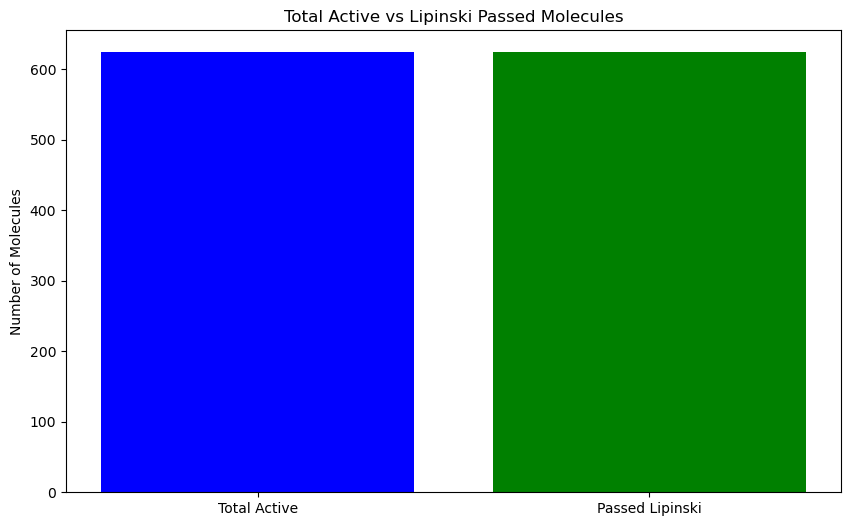

In [24]:
active_only_df['lipinski'] = active_only_df['Molecule'].apply(lipinski_rule_of_five)

# Filter to create a new DataFrame with only molecules that passed Lipinski's Rule
lipinski_passed_df = active_only_df[active_only_df['lipinski']].copy()

# Plotting the total active vs those that passed Lipinski's Rule
total_active = len(active_only_df)
passed_lipinski = len(lipinski_passed_df)

plt.figure(figsize=(10, 6))
plt.bar(["Total Active", "Passed Lipinski"], [total_active, passed_lipinski], color=['blue', 'green'])
plt.ylabel('Number of Molecules')
plt.title('Total Active vs Lipinski Passed Molecules')
plt.show()

In [26]:
active_only_df[active_only_df['lipinski'] == True]

,Molecule,is_valid,is_active,lipinski
2,C=CCCN1C[C@@H](C)[C@H](CCNC(=O)COc2ccco2)C1,1,1,True
9,CC1(C(=O)NC[C@@H](CO)NC(=O)C(C)(C)c2cnc[nH]2)C...,1,1,True
50,CC(=O)NCC(=O)NCc1cn(C2CN([C@@H](C)C(=O)N(C)C)C...,1,1,True
51,C=CCCCC(=O)N1CCn2c(nnc2C(=O)N2CC=CC2)C[C@@H]1C,1,1,True
52,CCn1ncc(CNC[C@@H]2CN(C(=O)Cn3ncnn3)CCO2)n1,1,1,True
...,...,...,...,...
9884,Cc1cnc([C@H](C)N2[C@H]3CC[C@H]2CN(C(=O)[C@H](C...,1,1,True
9886,CN1CC[C@](O)(CNS(=O)(=O)N2CC[C@@H](C(C)(C)C)C2)C1,1,1,True
9903,Cn1nnnc1NC(=O)CN[C@H]1CCC2(C1)OCCO2,1,1,True
9912,Cn1nncc1CN[C@@H]1CC[C@@H]2CN(C(=O)C3CCC3)C[C@@...,1,1,True


In [27]:
target_molecules_df = pd.read_csv("datasets/target_molecules_clean_2.csv")
target_molecules_df

,canonical_smiles,pIC50,ECFP4_0,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,...,ECFP4_2038,ECFP4_2039,ECFP4_2040,ECFP4_2041,ECFP4_2042,ECFP4_2043,ECFP4_2044,ECFP4_2045,ECFP4_2046,ECFP4_2047
0,O=C(O)/C=C/c1ccc(OS(=O)(=O)O)cc1,-0.301030,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CN(CCCNC(=O)c1ccc(O)cc1)CCCNC(=O)c1ccc(O)cc1,-0.301030,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CCN(CCCN(CC)C(=O)c1ccc(O)cc1)C(=O)c1ccc(O)cc1,-0.301030,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CN(CCCNC(=O)c1ccc(O)cc1)CCCNC(=O)c1ccc2cc(O)cc...,3.531653,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CCN(CCOC(=O)/C=C/c1ccc(O)cc1)Cc1cc(Cl)ccc1O,4.337242,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1557,Cc1ccc(S(=O)(=O)Nc2ccc(-c3nnc(SCc4ccc(C(F)(F)F...,4.598599,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1558,Cc1ccc(S(=O)(=O)Nc2ccc(-c3nnc(SCc4cccc(C(F)(F)...,4.621602,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1559,Cc1ccc(S(=O)(=O)Nc2ccc(-c3nnc(SCc4ccccc4C(F)(F...,4.619789,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1560,O=C(N[C@@H](Cc1ccc(O)cc1)C(=O)O)c1cc(-c2ccccc2...,5.017277,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# Find common molecules between the two dataframes
common_molecules = lipinski_passed_df[lipinski_passed_df['Molecule'].isin(target_molecules_df['canonical_smiles'])]

# Count the number of common molecules
num_common_molecules = len(common_molecules)

print("Number of common molecules:", num_common_molecules)
print("Common molecules:\n", common_molecules)

Number of common molecules: 0
Common molecules:
 Empty DataFrame
Columns: [Molecule, is_valid, is_active, lipinski]
Index: []


In [32]:
lipinski_passed_df.to_csv("datasets/active_passed_molecules.csv", index=False)

In [33]:
lipinski_passed_df

,Molecule,is_valid,is_active,lipinski
2,C=CCCN1C[C@@H](C)[C@H](CCNC(=O)COc2ccco2)C1,1,1,True
9,CC1(C(=O)NC[C@@H](CO)NC(=O)C(C)(C)c2cnc[nH]2)C...,1,1,True
50,CC(=O)NCC(=O)NCc1cn(C2CN([C@@H](C)C(=O)N(C)C)C...,1,1,True
51,C=CCCCC(=O)N1CCn2c(nnc2C(=O)N2CC=CC2)C[C@@H]1C,1,1,True
52,CCn1ncc(CNC[C@@H]2CN(C(=O)Cn3ncnn3)CCO2)n1,1,1,True
...,...,...,...,...
9884,Cc1cnc([C@H](C)N2[C@H]3CC[C@H]2CN(C(=O)[C@H](C...,1,1,True
9886,CN1CC[C@](O)(CNS(=O)(=O)N2CC[C@@H](C(C)(C)C)C2)C1,1,1,True
9903,Cn1nnnc1NC(=O)CN[C@H]1CCC2(C1)OCCO2,1,1,True
9912,Cn1nncc1CN[C@@H]1CC[C@@H]2CN(C(=O)C3CCC3)C[C@@...,1,1,True


In [47]:
# Filtering target molecules where pIC50 > 5.0
target_molecules_filtered_df = target_molecules_df[target_molecules_df['pIC50'] > 5.0]

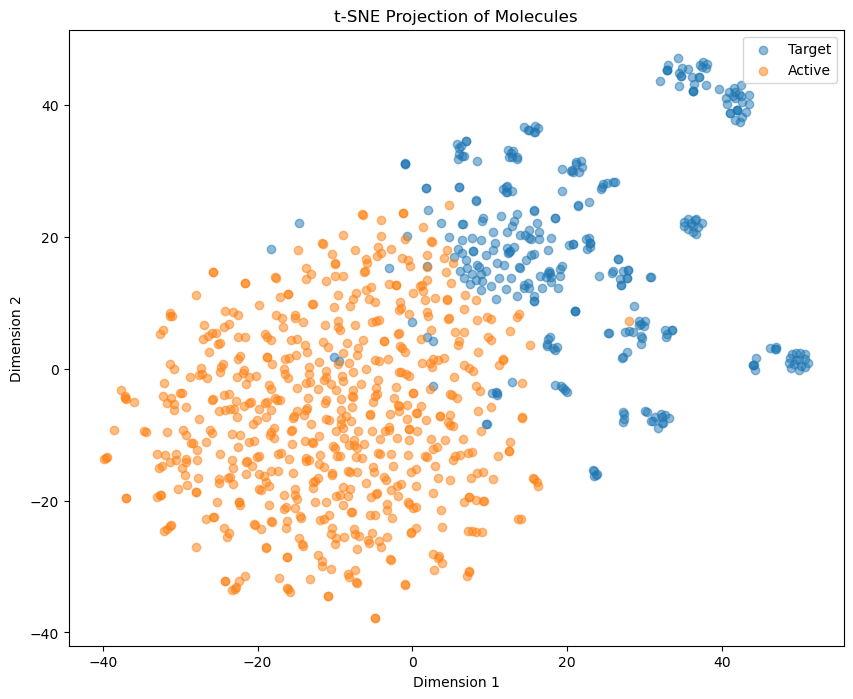

In [48]:
from sklearn.manifold import TSNE

# Extracting canonical smiles from both datasets
active_smiles = lipinski_passed_df['Molecule']
target_smiles = target_molecules_filtered_df['canonical_smiles']

# Combining the two sets of SMILES for t-SNE analysis
all_smiles = pd.concat([active_smiles, target_smiles]).unique()

# Generate Morgan fingerprints for the molecules
fingerprints = []
dataset_labels = []  # To track which dataset each fingerprint belongs to
for smiles in all_smiles:
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    fingerprints.append(fp)
    dataset_labels.append('Active' if smiles in active_smiles.values else 'Target')

# Convert fingerprints to a format suitable for t-SNE
fp_array = np.array(fingerprints)

# t-SNE projection
tsne = TSNE(n_components=2, random_state=42)
projected = tsne.fit_transform(fp_array)

# Plotting
plt.figure(figsize=(10, 8))
for i, label in enumerate(set(dataset_labels)):
    indices = [j for j, x in enumerate(dataset_labels) if x == label]
    plt.scatter(projected[indices, 0], projected[indices, 1], alpha=0.5, label=label)

plt.title('t-SNE Projection of Molecules')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

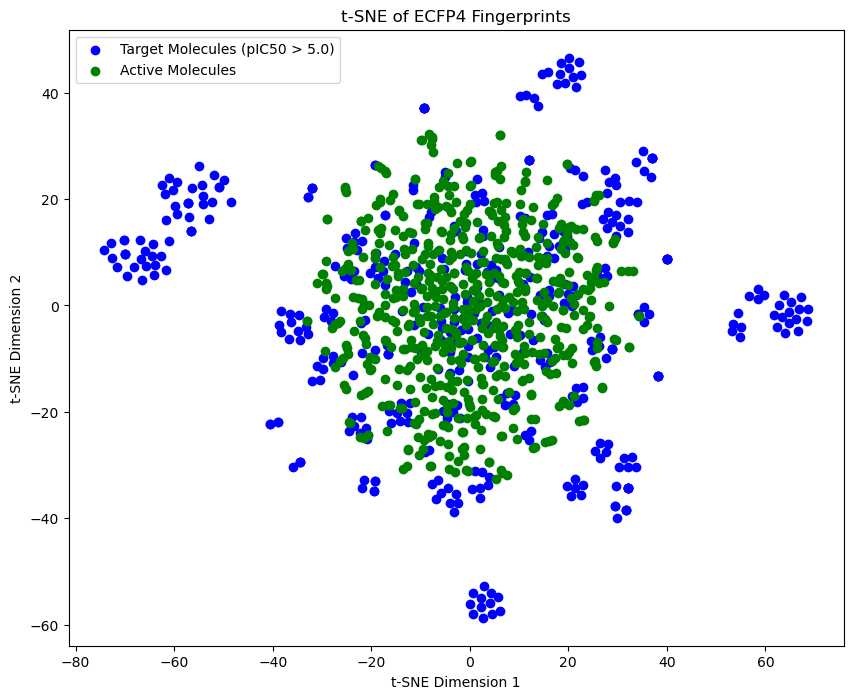

In [53]:
# Compute ECFP4 fingerprints for active molecules
active_molecules = lipinski_passed_df['Molecule'].apply(Chem.MolFromSmiles)
active_ecfp4 = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048) for mol in active_molecules]

# Compute ECFP4 fingerprints for target molecules
target_molecules = target_molecules_filtered_df['canonical_smiles'].apply(Chem.MolFromSmiles)
target_ecfp4 = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048) for mol in target_molecules]

# Convert ECFP4 fingerprints to numpy arrays
active_ecfp4_np = np.array([list(fp) for fp in active_ecfp4])
target_ecfp4_np = np.array([list(fp) for fp in target_ecfp4])

# Perform t-SNE only on target molecules
tsne = TSNE(n_components=2, random_state=42)
target_ecfp4_tsne = tsne.fit_transform(target_ecfp4_np)

# Apply the same transformation to active molecules
active_ecfp4_tsne = tsne.fit_transform(active_ecfp4_np)

# Plotting
plt.figure(figsize=(10, 8))

# Plotting target molecules in blue
plt.scatter(target_ecfp4_tsne[:, 0], target_ecfp4_tsne[:, 1], 
            color='blue', label='Target Molecules (pIC50 > 5.0)')

# Plotting active molecules in green
plt.scatter(active_ecfp4_tsne[:, 0], active_ecfp4_tsne[:, 1], 
            color='green', label='Active Molecules')

plt.title('t-SNE of ECFP4 Fingerprints')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()